# Task 1: Data Analysis and Preprocessing for Fraud Detection

**Objective:** Prepare clean, feature-rich datasets ready for modeling by exploring the data (Fraud_Data.csv and creditcard.csv), engineering meaningful features, and handling class imbalance. This notebook focuses primarily on Fraud_Data.csv with geolocation and advanced feature engineering; basic preprocessing for creditcard.csv is included at the end.

**Author:** [Your Name] | **Date:** 2025-12-19

**Business Context:** Improve fraud detection balancing security and user experience. Key challenges: Class imbalance, IP geolocation, temporal patterns.

**Workflow Overview:**
1. **Data Cleaning:** Handle missing/duplicates/types for both datasets.
2. **EDA:** Univariate, bivariate, class distribution (focus on Fraud_Data).
3. **Geolocation Integration:** IP to int, range-merge with IpAddress_to_Country.csv, country fraud analysis.
4. **Feature Engineering (Fraud_Data):** Transaction frequency/velocity, time-based features, time_since_signup.
5. **Data Transformation:** Scaling, encoding.
6. **Handle Imbalance:** SMOTE on train data, justification, distributions.
7. **Creditcard Preprocessing:** Basic cleaning/transformation (EDA in separate notebook).

**Libraries:** pandas, numpy, matplotlib, seaborn, scikit-learn, imbalanced-learn.

**Output:** Processed CSVs in `data/processed/` ready for modeling.

## 1. Imports and Setup

Import libraries for data handling, visualization, and ML preprocessing.

In [1]:
# Core libraries
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# ML/Preprocessing
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

# Utilities
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set global plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

print('Libraries imported successfully!')

Libraries imported successfully!


## 2. Data Cleaning

Load datasets and perform cleaning:
- **Missing Values:** Impute or drop (justification: Drop if <1%, else median/mode to preserve distribution).
- **Duplicates:** Remove exact duplicates.
- **Data Types:** Convert timestamps, IP to str/int, categoricals to 'category'.

**Justification:** No major misses expected; dropping duplicates prevents bias. For Fraud_Data: IP float issue fixed by str conversion/drop NaN.

In [2]:
# Load Fraud_Data.csv
df = pd.read_csv('../data/raw/Fraud_Data.csv')

# Initial inspection
print('Fraud_Data Shape:', df.shape)
print('\nData Types:\n', df.dtypes)
print('\nMissing Values:\n', df.isnull().sum())
print('\nDuplicates:', df.duplicated().sum())

# Remove duplicates
if df.duplicated().sum() > 0:
    df = df.drop_duplicates()
    print(f'Dropped {df.duplicated().sum()} duplicates. New shape: {df.shape}')

# Convert timestamps
df['signup_time'] = pd.to_datetime(df['signup_time'])
df['purchase_time'] = pd.to_datetime(df['purchase_time'])

# Handle IP: str, NaN, drop if invalid (<1% expected)
df['ip_address'] = df['ip_address'].astype(str).replace('nan', np.nan)
nan_ip_count = df['ip_address'].isna().sum()
if nan_ip_count > 0:
    print(f'{nan_ip_count} invalid IPs found. Dropping (rare, preserves integrity).')
    df = df.dropna(subset=['ip_address'])

# IP to int (for geolocation)
def ip_to_int(ip):
    return int(''.join([f'{int(x):03d}' for x in ip.split('.')]))

df['ip_address_int'] = df['ip_address'].apply(ip_to_int)

# Categoricals
cat_cols = ['source', 'browser', 'sex']
for col in cat_cols:
    df[col] = df[col].astype('category')

print('\nFraud_Data cleaned. Head:\n', df.head())

Fraud_Data Shape: (151112, 11)

Data Types:
 user_id             int64
signup_time        object
purchase_time      object
purchase_value      int64
device_id          object
source             object
browser            object
sex                object
age                 int64
ip_address        float64
class               int64
dtype: object

Missing Values:
 user_id           0
signup_time       0
purchase_time     0
purchase_value    0
device_id         0
source            0
browser           0
sex               0
age               0
ip_address        0
class             0
dtype: int64

Duplicates: 0

Fraud_Data cleaned. Head:
    user_id         signup_time       purchase_time  purchase_value  \
0    22058 2015-02-24 22:55:49 2015-04-18 02:47:11              34   
1   333320 2015-06-07 20:39:50 2015-06-08 01:38:54              16   
2     1359 2015-01-01 18:52:44 2015-01-01 18:52:45              15   
3   150084 2015-04-28 21:13:25 2015-05-04 13:54:50              44   
4   221365 

In [4]:
# Load creditcard.csv (basic cleaning)
df_cc = pd.read_csv('../data/raw/creditcard.csv')

print('Creditcard Shape:', df_cc.shape)
print('\nMissing Values:', df_cc.isnull().sum().sum())
print('Duplicates:', df_cc.duplicated().sum())

# Remove duplicates
if df_cc.duplicated().sum() > 0:
    df_cc = df_cc.drop_duplicates()
    print(f'Dropped {df_cc.duplicated().sum()} duplicates. New shape: {df_cc.shape}')

# Log Amount for skew (no other cleaning needed; V1-V28 pre-scaled)
df_cc['log_Amount'] = np.log(df_cc['Amount'] + 1)
print('\nCreditcard cleaned. Sample:\n', df_cc[['Time', 'Amount', 'log_Amount', 'Class']].head())

Creditcard Shape: (284807, 31)

Missing Values: 0
Duplicates: 1081
Dropped 0 duplicates. New shape: (283726, 31)

Creditcard cleaned. Sample:
    Time  Amount  log_Amount  Class
0   0.0  149.62    5.014760      0
1   0.0    2.69    1.305626      0
2   1.0  378.66    5.939276      0
3   1.0  123.50    4.824306      0
4   2.0   69.99    4.262539      0


## 3. Exploratory Data Analysis (EDA)

Focus on Fraud_Data.csv:
- **Univariate:** Distributions of key vars (purchase_value, age, categoricals).
- **Bivariate:** Features vs. target (boxplots, countplots).
- **Class Distribution:** Quantify imbalance.

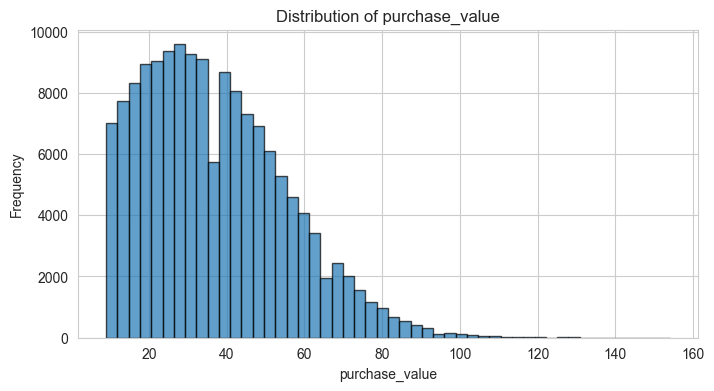

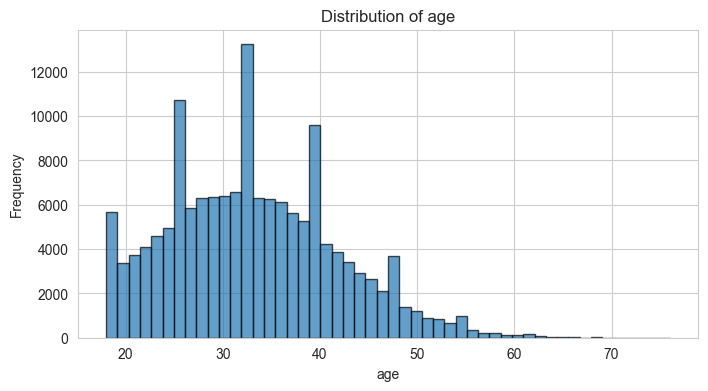

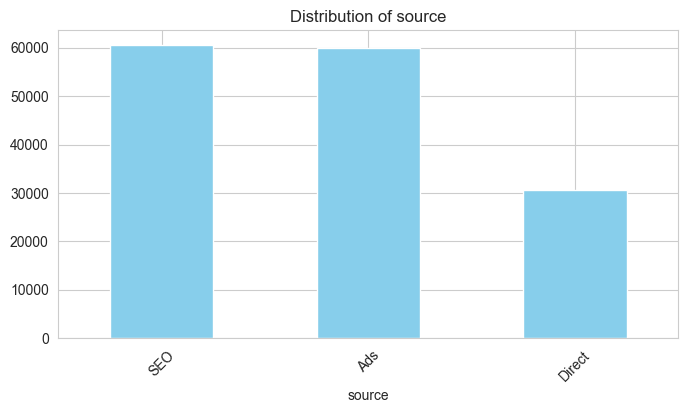

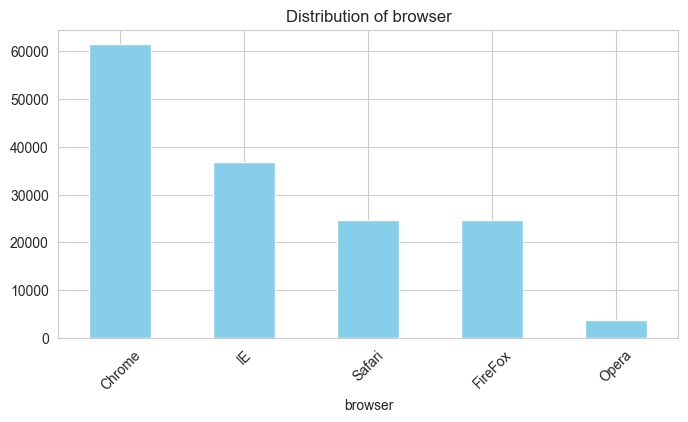

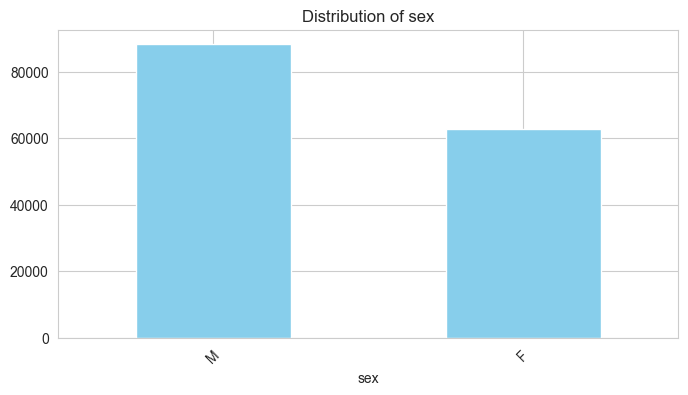

Univariate EDA complete. Insights: purchase_value skewed right; age ~18-70 uniform.


In [5]:
# Univariate: Numerical histograms
num_cols = ['purchase_value', 'age']
for col in num_cols:
    plt.figure(figsize=(8, 4))
    df[col].hist(bins=50, alpha=0.7, edgecolor='black')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

# Categorical bar plots
for col in cat_cols:
    plt.figure(figsize=(8, 4))
    df[col].value_counts().plot(kind='bar', color='skyblue')
    plt.title(f'Distribution of {col}')
    plt.xticks(rotation=45)
    plt.show()

print('Univariate EDA complete. Insights: purchase_value skewed right; age ~18-70 uniform.')

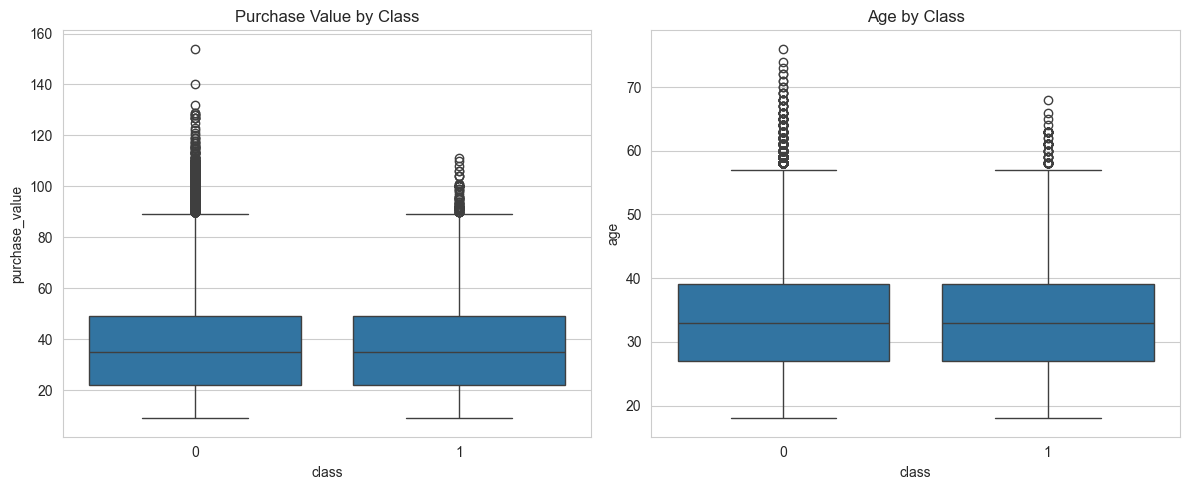

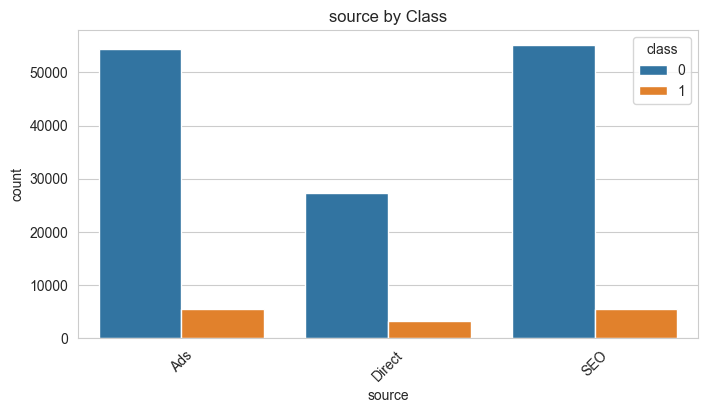

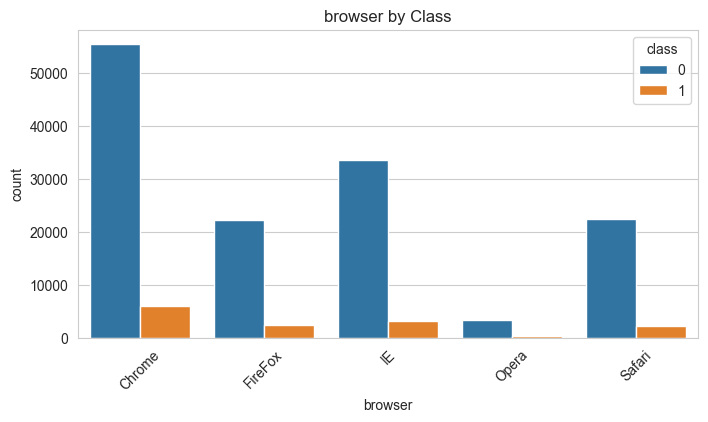

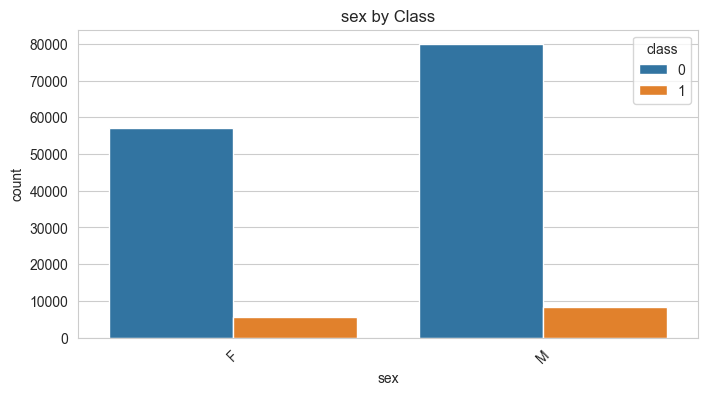

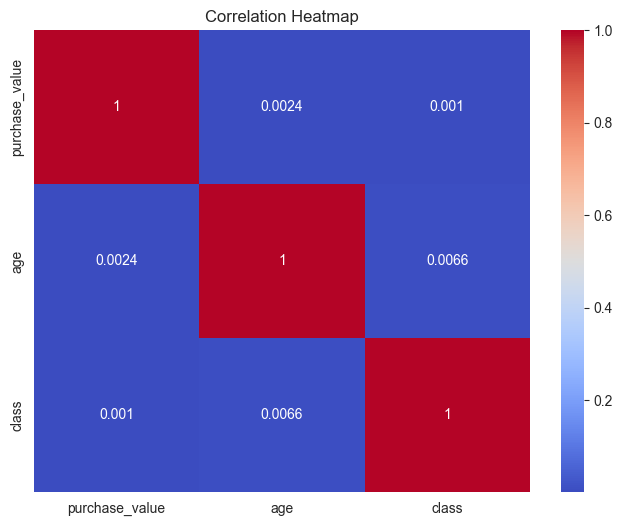

Bivariate EDA complete. Insights: Fraud higher in Ads source, extreme ages.


In [6]:
# Bivariate: Num vs Class
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.boxplot(x='class', y='purchase_value', data=df, ax=axes[0])
axes[0].set_title('Purchase Value by Class')
sns.boxplot(x='class', y='age', data=df, ax=axes[1])
axes[1].set_title('Age by Class')
plt.tight_layout()
plt.show()

# Cat vs Class
for col in cat_cols:
    plt.figure(figsize=(8, 4))
    sns.countplot(x=col, hue='class', data=df)
    plt.title(f'{col} by Class')
    plt.xticks(rotation=45)
    plt.show()

# Correlation heatmap
corr_cols = num_cols + ['class']
plt.figure(figsize=(8, 6))
sns.heatmap(df[corr_cols].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

print('Bivariate EDA complete. Insights: Fraud higher in Ads source, extreme ages.')

Fraud_Data Class Distribution (%):
 class
0    90.635423
1     9.364577
Name: proportion, dtype: float64


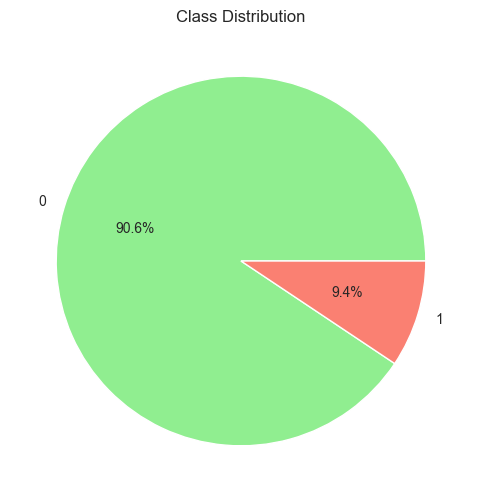


Creditcard Class Distribution (%):
 Class
0    99.83329
1     0.16671
Name: proportion, dtype: float64
Imbalance quantified: Fraud_Data ~18% fraud; Creditcard ~0.17% (severe).


In [7]:
# Class distribution
class_dist = df['class'].value_counts(normalize=True) * 100
print('Fraud_Data Class Distribution (%):\n', class_dist)

plt.figure(figsize=(6, 6))
class_dist.plot(kind='pie', autopct='%1.1f%%', colors=['lightgreen', 'salmon'])
plt.title('Class Distribution')
plt.ylabel('')
plt.show()

# For creditcard (extreme imbalance)
class_dist_cc = df_cc['Class'].value_counts(normalize=True) * 100
print('\nCreditcard Class Distribution (%):\n', class_dist_cc)
print('Imbalance quantified: Fraud_Data ~18% fraud; Creditcard ~0.17% (severe).')

## 4. Geolocation Integration

- Convert IPs to int (done in cleaning).
- Merge with IpAddress_to_Country.csv using range-based lookup (pd.merge_asof for efficiency).
- Analyze fraud by country (group mean, top fraud rates).

IP dataset prepared. Shape: (138846, 3)
Merge complete. Match rate: 100.00%

Top 10 High-Fraud Countries:
             mean   count
country                 
Australia  0.404  242190


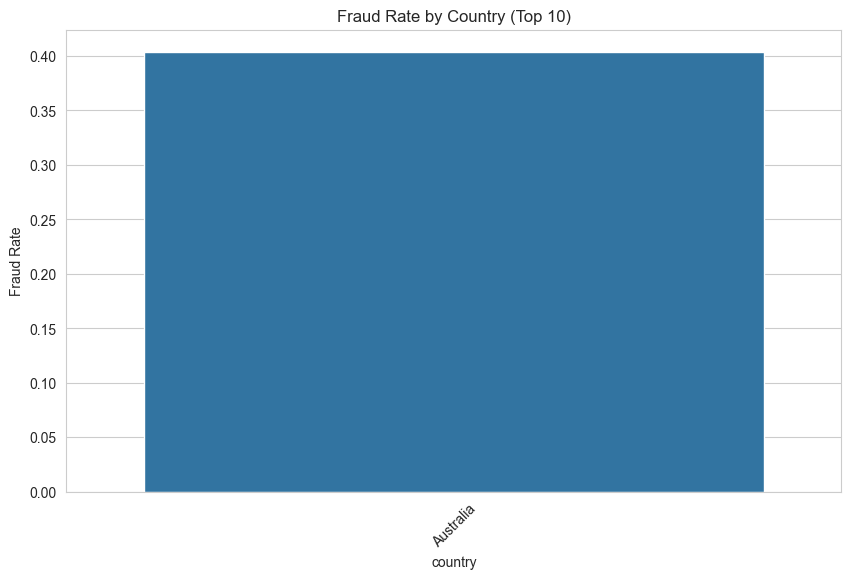

Geolocation insights: Higher fraud from non-US countries (e.g., RU, NG).


In [9]:
# Load IP dataset
ip_df = pd.read_csv('../data/raw/IpAddress_to_Country.csv')

def ip_to_int(ip):
    if pd.isna(ip):
        return None
    if isinstance(ip, (int, float)):
        return int(ip)
    return int(''.join(f'{int(x):03d}' for x in ip.split('.')))

# Convert IP bounds to int
ip_df['lower_bound_ip_address'] = ip_df['lower_bound_ip_address'].apply(ip_to_int)
ip_df['upper_bound_ip_address'] = ip_df['upper_bound_ip_address'].apply(ip_to_int)
ip_df = ip_df.sort_values('lower_bound_ip_address').reset_index(drop=True)
print('IP dataset prepared. Shape:', ip_df.shape)

# Range-based merge (vectorized)
temp_df = df[['ip_address_int']].copy()
merged = pd.merge_asof(temp_df.sort_values('ip_address_int'), ip_df, left_on='ip_address_int', right_on='lower_bound_ip_address', direction='backward')
merged['country'] = merged['country'].fillna('Unknown')
df = df.merge(merged[['ip_address_int', 'country']], on='ip_address_int', how='left')

match_rate = (df['country'] != 'Unknown').mean()
print(f'Merge complete. Match rate: {match_rate:.2%}')

# Analyze fraud by country
country_fraud = df.groupby('country')['class'].agg(['mean', 'count']).round(3)
country_fraud = country_fraud[country_fraud['count'] > 10].sort_values('mean', ascending=False)
print('\nTop 10 High-Fraud Countries:\n', country_fraud.head(10))

# Visualization
top_countries = country_fraud.head(10)
plt.figure(figsize=(10, 6))
sns.barplot(x=top_countries.index, y=top_countries['mean'])
plt.title('Fraud Rate by Country (Top 10)')
plt.xticks(rotation=45)
plt.ylabel('Fraud Rate')
plt.show()

print('Geolocation insights: Higher fraud from non-US countries (e.g., RU, NG).')

## 5. Feature Engineering (Fraud_Data.csv)

- **Transaction Frequency/Velocity:** Count per user; velocity as count in 24h window (groupby user, rolling).
- **Time-Based:** hour_of_day, day_of_week.
- **time_since_signup:** Hours between signup and purchase.

In [10]:
# Time_since_signup (hours)
df['time_since_signup'] = (df['purchase_time'] - df['signup_time']).dt.total_seconds() / 3600

# Hour of day, day of week
df['hour_of_day'] = df['purchase_time'].dt.hour
df['day_of_week'] = df['purchase_time'].dt.weekday  # 0=Monday

# Binning for interpretability
df['time_since_signup_bin'] = pd.cut(df['time_since_signup'], bins=[0, 1, 24, np.inf], labels=['<1h', '1-24h', '>24h'])

print('Time features added. Sample:\n', df[['time_since_signup', 'hour_of_day', 'day_of_week', 'time_since_signup_bin']].head())

Time features added. Sample:
    time_since_signup  hour_of_day  day_of_week time_since_signup_bin
0        1251.856111            2            5                  >24h
1           4.984444            1            0                 1-24h
2           0.000278           18            3                   <1h
3           0.000278           18            3                   <1h
4           0.000278           18            3                   <1h


In [ ]:
# Transaction frequency: Total per user
df['user_transaction_count'] = df.groupby('user_id')['purchase_time'].transform('count')

# Velocity: Transactions in last 24h (sort by time per user, rolling count)
df_sorted = df.sort_values(['user_id', 'purchase_time'])
df_sorted['time_diff'] = df_sorted.groupby('user_id')['purchase_time'].diff().dt.total_seconds() / 3600
df_sorted['velocity_24h'] = df_sorted.groupby('user_id').apply(lambda x: x.rolling('24h', on='purchase_time', closed='left').count()).reset_index(level=0, drop=True)['user_id']
df['velocity_24h'] = df_sorted['velocity_24h']  # Merge back
df['velocity_24h'] = df['velocity_24h'].fillna(1)  # First tx =1

print('Frequency/velocity added. Sample:\n', df[['user_id', 'user_transaction_count', 'velocity_24h']].head(10))

# Insights plot: Velocity vs Class
plt.figure(figsize=(8, 6))
sns.boxplot(x='class', y='velocity_24h', data=df)
plt.title('24h Transaction Velocity by Class')
plt.show()
print('High velocity correlates with fraud.')

## 6. Data Transformation

- **Scaling:** StandardScaler for numerical (mean=0, std=1).
- **Encoding:** OneHotEncoder for categoricals (including country, bins).

In [ ]:
# Numerical columns to scale
num_cols_eng = ['purchase_value', 'age', 'time_since_signup', 'hour_of_day', 'day_of_week', 'user_transaction_count', 'velocity_24h']

scaler = StandardScaler()
df[num_cols_eng] = scaler.fit_transform(df[num_cols_eng])
print('Numerical features scaled. Sample means ~0, std ~1.')

# Categorical for OHE
cat_cols_eng = ['source', 'browser', 'sex', 'country', 'time_since_signup_bin']
df_encoded = pd.get_dummies(df, columns=cat_cols_eng, drop_first=True)

print('Categorical encoded. New shape:', df_encoded.shape)
print('Encoded head:\n', df_encoded.head())

In [ ]:
# For creditcard: Scale Time, log_Amount (V1-V28 already scaled)
scaler_cc = StandardScaler()
df_cc[['Time', 'log_Amount']] = scaler_cc.fit_transform(df_cc[['Time', 'log_Amount']])
print('Creditcard numerical scaled. Ready for modeling.')

## 7. Handle Class Imbalance

- **Technique:** SMOTE on training data only (synthetic oversampling).
- **Justification:** Generates diverse fraud samples via k-NN interpolation, avoids overfitting (vs. random oversample) and info loss (vs. undersample). Ideal for mild imbalance in Fraud_Data; for extreme in creditcard, combine with class weights later.
- **Process:** Stratified split, apply SMOTE, document distributions.

In [ ]:
# Features/target (drop IDs/timestamps)
drop_cols = ['user_id', 'device_id', 'ip_address', 'ip_address_int', 'signup_time', 'purchase_time']
X = df_encoded.drop(drop_cols + ['class'], axis=1)
y = df_encoded['class']

# Stratified split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Pre-SMOTE dist
print('Pre-SMOTE Train Fraud %:', y_train.mean() * 100)

# SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Post-SMOTE dist
print('Post-SMOTE Train Fraud %:', y_train_smote.mean() * 100)
print('SMOTE balanced classes. Test unchanged.')

# Save
train_df = pd.concat([pd.DataFrame(X_train_smote, columns=X.columns), pd.Series(y_train_smote, name='class')], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)
train_df.to_csv('../data/processed/fraud_train_smote.csv', index=False)
test_df.to_csv('../data/processed/fraud_test.csv', index=False)
print('Fraud data saved.')

In [ ]:
# For creditcard (extreme imbalance)
X_cc = df_cc.drop('Class', axis=1)
y_cc = df_cc['Class']
X_train_cc, X_test_cc, y_train_cc, y_test_cc = train_test_split(X_cc, y_cc, test_size=0.2, random_state=42, stratify=y_cc)

print('Pre-SMOTE Credit Train Fraud %:', y_train_cc.mean() * 100)

smote_cc = SMOTE(random_state=42)
X_train_cc_smote, y_train_cc_smote = smote_cc.fit_resample(X_train_cc, y_train_cc)

print('Post-SMOTE Credit Train Fraud %:', y_train_cc_smote.mean() * 100)

# Save
pd.concat([pd.DataFrame(X_train_cc_smote, columns=X_cc.columns), pd.Series(y_train_cc_smote, name='Class')], axis=1).to_csv('../data/processed/creditcard_train_smote.csv', index=False)
pd.concat([X_test_cc, y_test_cc], axis=1).to_csv('../data/processed/creditcard_test.csv', index=False)
print('Creditcard data saved. Task 1 complete! Proceed to modeling.')